# 01 Cleaning the Data

Author: Harry Yau

Date: Aug 28, 2019

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import glob as glob
import pickle
import re
import seaborn as sns

### Loading the Data

In [2]:
def standardize_colnames(colnames):
    for i, val in enumerate(colnames):
        if 'Departure temperature' in val:
            colnames[i] = 'Departure temperature'
        if 'Return temperature' in val:
            colnames[i] = 'Return temperature'
        if 'Stopover duration' in val:
            colnames[i] = 'Stopover duration'
        if 'Membership type' in val:
            colnames[i] = 'Membership Type'
        if 'Formula' in val:
            colnames[i] = 'Membership Type'
            
    return(colnames)

In [3]:
pickle_folder = 'pickle'

#Data that has all the bike station info. It was pre-processed.
station_info_df = pd.read_csv('data/station_data.csv', dtype={'id': str, 'name': str, 'lat': float, 'lon': float, 'total_slots':int})

#Loading pre-loaded CSV files that was loaded into memory and saved as a pickle file. Please check another notebook
filename = 'loaded_mobi_data.pkl'
infile = open('pickle' + '/'+ filename, 'rb')
data_list = pickle.load(infile)
infile.close()

#Filter the data by standardizing the columns. The provided CSV files all have different column names, and different data.
col_names_ref = data_list[0].columns
col_names_ref_list = standardize_colnames(list(col_names_ref))

for i, df in enumerate(data_list):
    data_list[i].columns = standardize_colnames(list(df.columns))
for i, d in enumerate(data_list):
    data_list[i] = d.reindex(columns=col_names_ref_list)

del col_names_ref, col_names_ref_list
    
#Combine all the data frames in the list.
combined_df = pd.concat(data_list, axis=0)
combined_df.reset_index(drop=True, inplace=True)

del data_list

#drop rows with departure station and return station being NA
combined_df = combined_df[~combined_df['Departure station'].isna()]
combined_df = combined_df[~combined_df['Return station'].isna()]

#To save space in memory, splitting the Departure and Return station names so that it only shows the
temp_dep=[]
temp_ret=[]

for i in combined_df['Departure station']:
    temp = re.split('\s', i, 1)
    temp_dep.append(temp[0])
    
for i in combined_df['Return station']:
    temp = re.split('\s', i, 1)
    temp_ret.append(temp[0])

combined_df['Departure station'] = temp_dep
combined_df['Return station'] = temp_ret

del temp_dep, temp_ret

#Remove non-existent stations. Pair up with master station list.
vec = combined_df['Departure station'].isin(station_info_df['id'])
combined_df = combined_df[vec]

vec = combined_df['Return station'].isin(station_info_df['id'])
combined_df = combined_df[vec]

#Convert to datetime..
combined_df['Departure'] = pd.to_datetime(combined_df['Departure'])
combined_df['Return'] = pd.to_datetime(combined_df['Return'])

del vec

Check the Size of the data frame for sanity reasons.

In [4]:
combined_df.shape

(1387272, 15)

### Adding Features

Adding 2 useful features: Adjusted Duration and Average Speed.

In [5]:
combined_df['Adj Duration (sec.)'] = (combined_df['Duration (sec.)']-combined_df['Stopover duration'])

combined_df['Average speed (km/h)'] = (combined_df['Covered distance (m)']/1000) / \
    ((combined_df['Adj Duration (sec.)'] )/3600)

### Cleaning the data

The goal of the data clean up is to filter out non-representative bike trips on the bike network.

### Remove entries with speeds over 60 km/hr and at 0 km/hr

Looking at the distribution for the Average speed, there appears to be some very large average speed. People can't bike that fast.

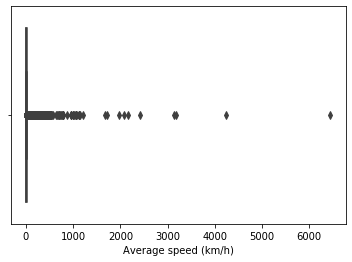

In [6]:
ax = sns.boxplot(x=combined_df.loc[:,['Average speed (km/h)']])
ax.set(xlabel='Average speed (km/h)');

Zoomed into Average speed below 60 km/h, this makes more sense.

C:\Users\yauha\Anaconda3\envs\tensorflowenv\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


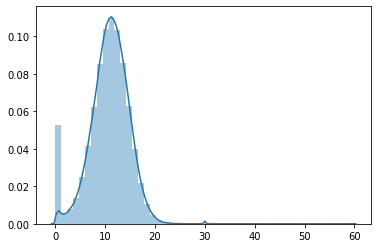

In [7]:
sns.distplot(combined_df.loc[(combined_df['Average speed (km/h)'] <= 60), ['Average speed (km/h)']], bins = 50);

In [8]:
# Remove bikes 
combined_df = combined_df[(combined_df['Average speed (km/h)'] <= 60) & (combined_df['Average speed (km/h)'] > 0)]

Peering into the left portion after slimming down the data 0 < km/hr < 60, there appears to be a lot of small values. It appears that these entries have a high covered distance. These entries are not going to be touched here for now. In the future these entries will be removed when Covered Distance is looked at in a future section.

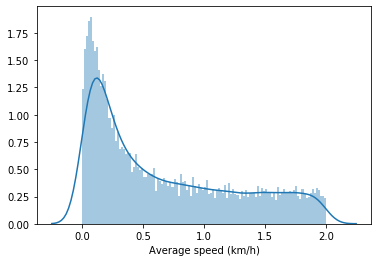

In [9]:
sns.distplot(combined_df['Average speed (km/h)'][combined_df['Average speed (km/h)']<2], bins = 120);

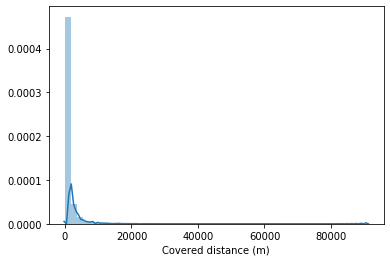

In [10]:
sns.distplot(combined_df['Covered distance (m)'][combined_df['Average speed (km/h)']<2]);

Current data shape size.

In [11]:
combined_df.shape

(1319115, 17)

### Duration

Duration and seconds # of trips...

Taking a look at the highest value in our data set, this entry is probably not representative of a typical bike trip. Looking at the box plot, there are some outlier data. Data that is above 3 hours (10800 seconds) are removed.

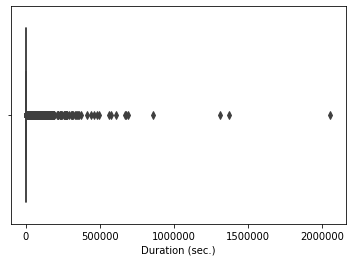

In [12]:
ax = sns.boxplot(x=combined_df['Duration (sec.)']);

In [13]:
# Remove bikes 
combined_df = combined_df[combined_df['Duration (sec.)'] <= 10800]

The following chart is to show after trimming of data.

C:\Users\yauha\Anaconda3\envs\tensorflowenv\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


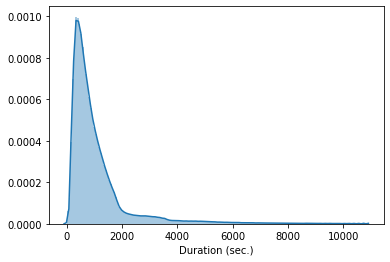

In [14]:
sns.distplot(combined_df['Duration (sec.)'], bins = list(range(0, 10800, 60)));

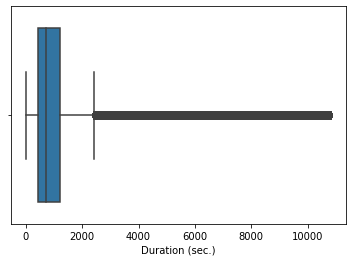

In [15]:
sns.boxplot(x=combined_df['Duration (sec.)']);

Current data shape size.

In [16]:
combined_df.shape

(1310799, 17)

### Distance

There appears to be outliers.

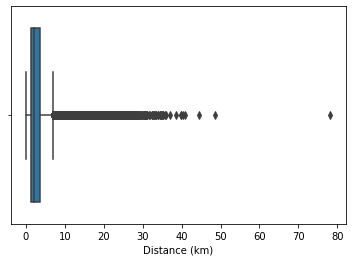

In [17]:
ax = sns.boxplot(x=combined_df['Covered distance (m)']/1000)
ax.set(xlabel='Distance (km)');

C:\Users\yauha\Anaconda3\envs\tensorflowenv\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


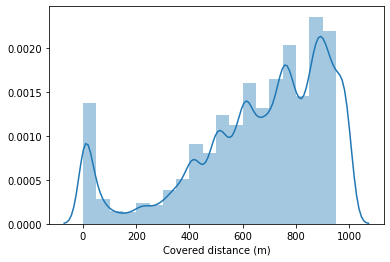

In [18]:
#meters
max_val = 1000

sns.distplot(combined_df['Covered distance (m)'][combined_df['Covered distance (m)'] <= max_val], 
             bins = list(range(0, max_val, 50)))

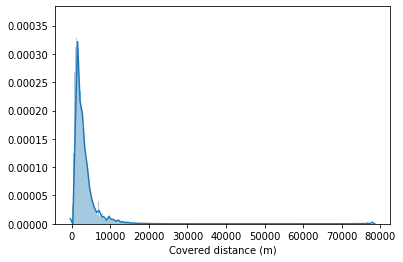

In [19]:
max_val = int(combined_df['Covered distance (m)'].max())
sns.distplot(combined_df['Covered distance (m)'], bins = list(range(0, max_val, 100)));

Observing the Distance vs Duration plot, there is a 1:1 line that shows up on the charts. This is probably caused by bugged data. Before the 1:1 line with the bugged data is removed, round trips that were under 90 seconds in duration is removed first. This is an assumption that trips under 90 seconds does not reflect a typical bike trip. Lastly, trips that went a distance under 100 m were removed also.

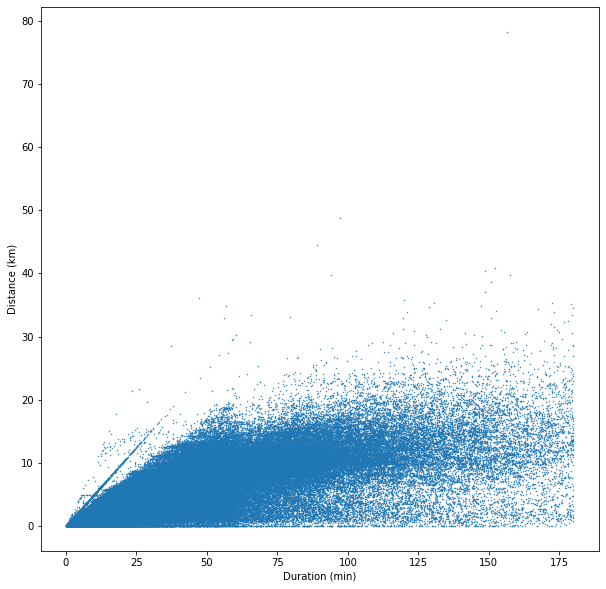

In [20]:
plt.figure(figsize = (10,10))
plt.scatter(combined_df['Duration (sec.)']/60, combined_df['Covered distance (m)']/1000, s=0.2)
plt.xlabel('Duration (min)')
plt.ylabel('Distance (km)');

In [21]:
# Remove rows where it was a round trip but under 90 seconds. Hence, it wasn't really a bike trip.
mark = (combined_df['Departure station'] == combined_df['Return station'])&( combined_df['Duration (sec.)'] <= 90)
combined_df = combined_df[~mark]

#Remove low covered distance between 100 m
mark = (combined_df['Covered distance (m)'] < 100)
combined_df = combined_df[~mark]

Investigating the 1:1 line again. There appears to be a a spike of a number of average speed at 30 km/hr and this could probably be a bugged odometer or timer.

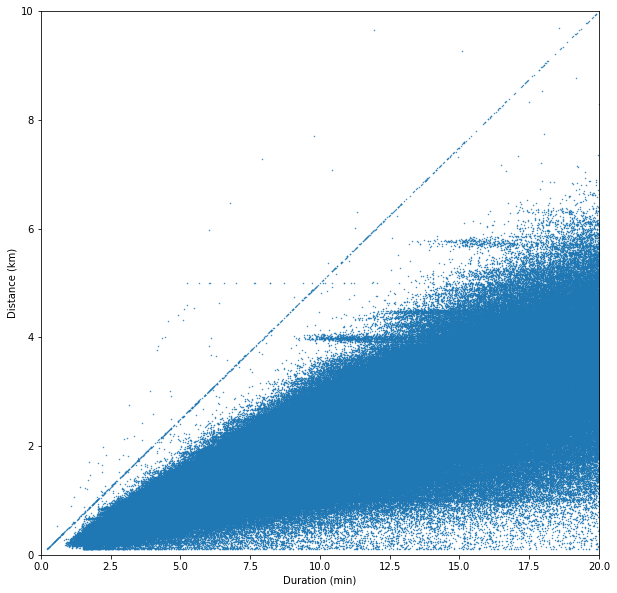

In [22]:
plt.figure(figsize = (10,10))
plt.scatter(combined_df['Duration (sec.)']/60, combined_df['Covered distance (m)']/1000, s=0.2)
plt.xlabel('Duration (min)')
plt.ylabel('Distance (km)')
plt.xlim(0,20)
plt.ylim(0,10);

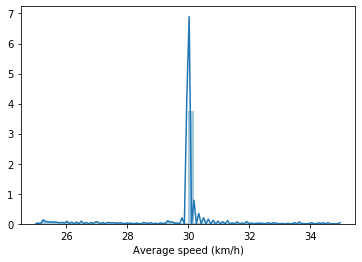

In [23]:
sns.distplot(combined_df['Average speed (km/h)']\
             [(combined_df['Average speed (km/h)'] > 25)&(combined_df['Average speed (km/h)'] < 35)], bins = 50);

The decision was made to remove all entries above 26 km/hr, after analyzing a chart where values between 28km/hr and 32 km/hr were removed. Now the data looks representative of how a typical user may use a bike. 

In [24]:
dev = 2
mark = (combined_df['Average speed (km/h)'] < (30 + dev)) & (combined_df['Average speed (km/h)'] > (30 - dev))

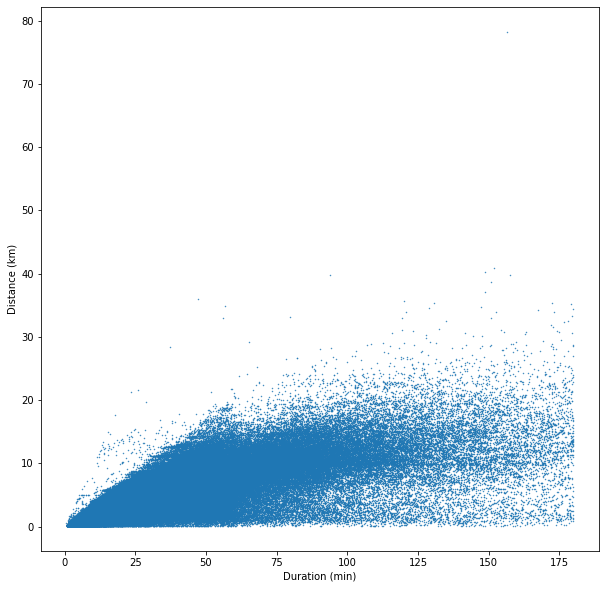

In [25]:
plt.figure(figsize = (10,10))
plt.scatter(combined_df['Duration (sec.)'][~mark]/60, combined_df['Covered distance (m)'][~mark]/1000, s=0.2)
plt.xlabel('Duration (min)')
plt.ylabel('Distance (km)');

In [26]:
#Remove above 26 km/hr

mark = (combined_df['Average speed (km/h)'] <= 26)

combined_df = combined_df[mark]

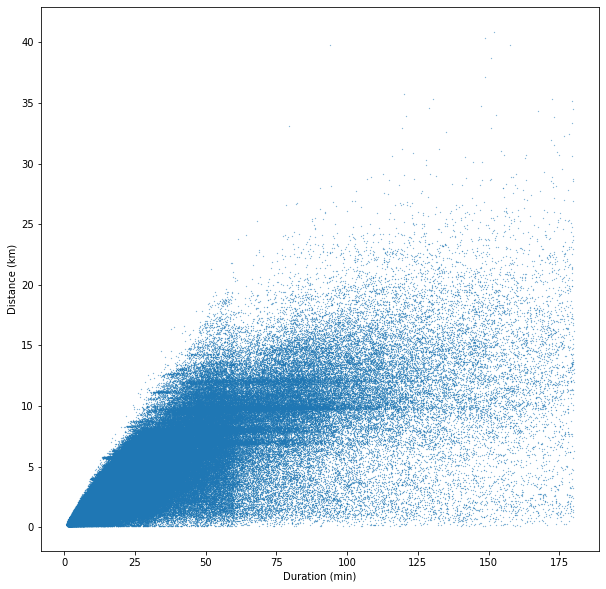

In [27]:
#Replot after data point removal.
plt.figure(figsize = (10,10))
plt.scatter(combined_df['Duration (sec.)']/60, combined_df['Covered distance (m)']/1000, s=0.05)
plt.xlabel('Duration (min)')
plt.ylabel('Distance (km)');

Current data shape size.

In [28]:
combined_df.shape

(1293376, 17)

### Loose Ends

The Account ID and Bike ID will be left as NAN to keep the entries for completeness. There is no need to remove the rows because the reason there is a NaN is due to a bugged sensor or software error that did not record those information.

For the 'Membership Type' data, the values that are NaN will be filled with the corresponding Account ID's top used Membership Type information.

In [29]:
combined_df.isna().sum()

Departure                             0
Return                                0
Account                           38371
Bike                                483
Departure station                     0
Return station                        0
Membership Type                     134
Covered distance (m)                  0
Duration (sec.)                       0
Departure battery voltage (mV)        0
Return battery voltage (mV)           0
Departure temperature                 0
Return temperature                    0
Stopover duration                     0
Number of stopovers                   0
Adj Duration (sec.)                   0
Average speed (km/h)                  0
dtype: int64

First Replace values where both Account and Membership Type are NaN. Membership Type of '24 hour' was chosen as the replacement value because it is assumed that these are single trip riders and not a recurrent user. Note: there was only two NaN accounts with NaN Membership Type info.

In [30]:
combined_df.loc[(combined_df['Account'].isna())&(combined_df['Membership Type'].isna()), 'Membership Type'] = '24 Hour'

In [31]:
accounts_member_isna = combined_df.loc[combined_df['Membership Type'].isna(), 'Account']

In [32]:
for id in accounts_member_isna:
    
    #There are some Account id's that are NA. For completeness, we are going to leave it in the data set.

    temp_df = combined_df.loc[(combined_df['Account']==id), 'Membership Type']

    #If there is no other entry, arbitrary fill in the value as '24 Hour'
    # Some of these ID have NAN values. Therefore they will only have 1 value.
    if (temp_df.shape[0] != 1):
        replace_value = temp_df.value_counts().index[0]
    else:
        replace_value = '24 Hour'
    
    combined_df.loc[(combined_df['Membership Type'].isna())&(combined_df['Account'] == id), 'Membership Type'] = replace_value

In [33]:
combined_df.isna().sum()

Departure                             0
Return                                0
Account                           38371
Bike                                483
Departure station                     0
Return station                        0
Membership Type                       0
Covered distance (m)                  0
Duration (sec.)                       0
Departure battery voltage (mV)        0
Return battery voltage (mV)           0
Departure temperature                 0
Return temperature                    0
Stopover duration                     0
Number of stopovers                   0
Adj Duration (sec.)                   0
Average speed (km/h)                  0
dtype: int64

### Touch up

In [34]:
combined_df.reset_index(drop=True, inplace=True)

In [35]:
combined_df.head()

,Departure,Return,Account,Bike,Departure station,Return station,Membership Type,Covered distance (m),Duration (sec.),Departure battery voltage (mV),Return battery voltage (mV),Departure temperature,Return temperature,Stopover duration,Number of stopovers,Adj Duration (sec.),Average speed (km/h)
0,2018-01-01,2018-01-01,ID00001,754.0,0048,0002,365 Day Founding Plus,1382.0,402,3715,3903,2,4,0,0,402,12.376119
1,2018-01-01,2018-01-01,ID00002,517.0,0093,0035,365 Day Founding Standard,1960.0,1015,3645,3795,0,1,0,0,1015,6.951724
2,2018-01-01,2018-01-01,ID00003,231.0,0071,0211,365 Corporate Plus,624.0,194,3650,3790,0,1,0,0,194,11.579381
3,2018-01-01,2018-01-01,ID00004,1302.0,0187,0079,365 Day Founding Plus,1756.0,571,3686,3868,2,3,0,0,571,11.071103
4,2018-01-01,2018-01-01,ID00005,1185.0,0114,0068,Archived Monthly Standard,518.0,242,3673,3774,0,1,0,0,242,7.705785


In [36]:
#Export to pickle file.

outfile = open(pickle_folder + '/' + 'mobi_cleaned.pkl','wb')
pickle.dump(combined_df, outfile)
outfile.close()